In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc

In [2]:
def find_fill_value(group):
    if pd.api.types.is_numeric_dtype(group):
        return group.mean()
    else:
        mode = pd.Series.mode(group, dropna=True)
        if not mode.empty:
            return mode[0] 
        else:
            return None

In [3]:
df = pd.read_csv("data/amazon_reviews.csv")

## Project Scope
In this project I will try to build a recommendation system that gives top 5 perosonalized recommendations for each customer, even for new, unknown customers.
In order to acheive this I will build and compare two models:
- Neural Network based on the embedded items and users information
- AlternatingLeastSquares model from implicit library that uses Matrix Factorization technique.

For the Neural Network I will use pretrained model to convert 'description' (representation of items), two concatenated list of items and reviews (users representation). The list of items stands for 'interaction' representation of a user, whereas list of reviews for 'behavioral' parrerns.  

## Data Cleaning
General steps that cannot introduce leakage and, thus, do not require to split data into training, validation, and test sets.

In [4]:
# Keep only columns that will be used
df = df[["userName", "itemName", "description", "price", "summary", "reviewTime", "rating", "reviewText"]]
# Reduce the number of rows before applying any preprocessing steps to make it more efficient
df = df.drop_duplicates(keep="first")

In [5]:
# In the spesicied columns get rid of possible HTML attributes, make text lower case, and delete special symbols
for col in ["userName", "itemName", "description", "summary", "reviewText"]:
    df.loc[:, col] = df[col].replace(to_replace=r"<.*?>", value="", regex=True)\
        .str.lower().replace(to_replace=r"[^\w\s]", value="", regex=True).str.strip()

# Extract numbers from 'price' column. If range is specified ($1.63 - $30.5) the mean value will be calculated
df.loc[:, "price"] = df["price"].str.extractall(r"\$ ?(\d{1,3}(?:,\d{3})*\.\d{2})")\
    .replace({r"\$": "", ",": ""}, regex=True)[0].astype(float)\
    .groupby(level=0).agg("mean").reindex(df.index, fill_value=np.nan)

df.loc[:, "reviewTime"] = pd.to_datetime(df["reviewTime"])

In [6]:
# For each item find the most popular 'description' and 'price' for each item and apply it to the entire item group
modes_means = df.groupby("itemName")[["description", "price"]].agg(find_fill_value)
for col in modes_means.columns:
    df.loc[:, col] = df["itemName"].map(modes_means[col])

# In cases where the 'reviewText' is missing try to use 'summary' instead to reduce number of missing reviews
df.loc[df["reviewText"].isna(), "reviewText"] = df.loc[df["reviewText"].isna(), "summary"]

In [7]:
# Cleaning the dataset
df = df.drop(columns=["summary"])
df = df.drop_duplicates(keep="first")
df = df.dropna(subset=["userName", "itemName", "description", "reviewText"], how="any")

In [8]:
# Make sure each item has only one description in the dataset
assert all(df[["itemName", "description"]].groupby("itemName").nunique() == 1)

There are two 'users' in the dataset with extremely large number of reviews:
- Amazon Customer
- Kindle Customer  

that have roughly 37,000 reviews together in the provided nine months of data. I assume that this is a representation of anrecognized customers. This status means that these users cannot be given personalized recommendations and should be treated as unknown customers. Moreover, their reviews also cannot be utilized. To achieve the desired effect I will exclude all records with these customers form training data (there is also no need to keep them in validation or test sets, since different logic will be applied)

In [9]:
df_filtered = df[~df["userName"].isin(["Amazon Customer", "Kindle Customer"])].copy().sort_values("reviewTime")

In [10]:
data_path = os.path.join(os.getcwd(), "data")
os.makedirs(data_path, exist_ok=True)

In [11]:
df.to_parquet(os.path.join(data_path, "clean_df.pq"))

## Data Preprocessing

In [5]:
from imblearn.under_sampling import RandomUnderSampler
from sentence_transformers import SentenceTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

/Users/oleg/Library/Caches/pypoetry/virtualenvs/amazon_reviews_recommender_system-BULYqcNi-py3.12/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/Users/oleg/Library/Caches/pypoetry/virtualenvs/amazon_reviews_recommender_system-BULYqcNi-py3.12/lib/python3.12/site-packages/sentence_transformers/evaluation/SentenceEvaluator.py:81: SyntaxWarning: invalid escape sequence '\g'
  return re.sub(r"([a-z])([A-Z])", "\g<1> \g<2>", class_name)
/Users/oleg/Library/Caches/pypoetry/virtualenvs/amazon_reviews_recommender_system-BULYqcNi-py3.12/lib/python3.12/site-packages/sentence_transformers/model_card.py:524: SyntaxWarning: invalid escape sequence '\d'
  if dataset_name and re.match("_dataset_\d+", dataset_name):
/Users/oleg/Library/Caches/pypoetry/virtualenvs/amazon_review

The goal is to provide the best possible recommendations (that would be rated with the highest score - 5) for users. This transforms the task into a binary classification problem. All the highest ratings will betreated as 'to recommend' (1), and all the others will be treated as 'to not recommend' (0). This approach will also help to deal with the dataset imbalance, combining four minority classes into one.

In [13]:
df_filtered.loc[df_filtered["rating"] != 5, "rating"] = 0
df_filtered.loc[df_filtered["rating"] == 5, "rating"] = 1

The dataset contains information abount the date of the rating, which means we can simulate real life behaviour, when we need to predict having only historical data. To do this, I will split the data into train, validation, and test sets taking into account 'reviewTime' feature.
For the train set I will use 80% of the data, and by 10% for each validation and test set:

In [14]:
# First calculate desired size of the sets
train_size = int(len(df_filtered) * 0.8)
test_size = int(len(df_filtered) * 0.1)

data = df_filtered.sort_values("reviewTime", ascending=True)
# Find the date in the last row of potential 'train' set
tr_last_value = data.iloc[:train_size]["reviewTime"].max()
# And separate all the data with dates before the maximum date including (this may result in a bit bigger size of dataset)
train = data[data["reviewTime"] <= tr_last_value].copy()

# Finde the date in the first row of potential 'test' set
te_first_value = data.iloc[-test_size: ]["reviewTime"].min()
# Ans separate all the dates after the minimum date not including (this may result in a bit smaller size of dataset)
test = data[data["reviewTime"] > te_first_value].copy()

# For the 'validation' set use all the data with dates in between including 'right' boundary
validation = data[data["reviewTime"].between(tr_last_value, te_first_value, inclusive="right")].copy()

Now I will create 'mapping' datasets for items and users.  
The set of items is not dependent on the date or any other circumstances - it is provided by the business owner. Contrary, the information about usets is always time dependen, and in this case only data collected before the end of 'training' time must be used.

In [15]:
# For items use full dataset before any filters
desc = df[["itemName", "description"]].drop_duplicates().set_index("itemName")
# For the users use only train dataset and apply concatenation all the relevant strings into one.
user_reviews = train.groupby("userName")["reviewText"].agg(lambda x: " ".join(x))
user_items = train.groupby("userName")["itemName"].agg(lambda x: " ".join(x))

Since the dataset is imbalanced, I will appy undersamping technique to train set to make both groups sizes equal.

In [16]:
rus = RandomUnderSampler(random_state=42)
train, y = rus.fit_resample(train.drop(columns="rating"), train["rating"])
train["rating"] = y

In [17]:
encoder = SentenceTransformer("all-MiniLM-L6-v2")

/Users/oleg/INSAIT/assignment/.venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [18]:
def get_embedded_df(encoder, data, name=""):
    # Encode 
    emb = encoder.encode(data, show_progress_bar=True, normalize_embeddings=True)
    # Transform into pandas DataFrame object
    emb_df = pd.DataFrame(emb, index=data.index)
    # Convert columns names into strings
    emb_df.columns = emb_df.columns.astype(str)
    if name:
        # Save the data for further use
        emb_df.to_parquet(name)
    return emb_df

In [19]:
def impute_missing(base, df, col, name=""):
    imputer = KNNImputer()
    # Use embedding dataframe as a bese for KNN search
    data = base.copy()
    
    # Add 'price' columns to the embedding dataframe
    data[col] = data.index.map(
        df.set_index(data.index.name)[col].astype(float).to_dict()
    )
    # impute missing values (expected to be only in the 'col', but generally it is not necessary)
    imputed = imputer.fit_transform(data)[:,-1]
    
    # Scale using RobustScales since outliers can significantly affect scaling
    scaler = RobustScaler()
    imputed = scaler.fit_transform(imputed.reshape(-1, 1))
    
    # Transform into pandas DataFrame object
    imputed_df = pd.DataFrame(imputed, index=data.index, columns=[col])
    if name:
        # Save the data for further use
        imputed_df.to_parquet(name)
    return imputed_df

In [20]:
embeddings_path = os.path.join(os.getcwd(), "embeddings")
os.makedirs(embeddings_path, exist_ok=True)

In [21]:
# item_desc_emb_df = get_embedded_df(encoder, desc["description"], os.path.join(embeddings_path, "item_desc_emb_df.pq"))
# item_price_df = impute_missing(base=item_desc_emb_df, df=df, col="price", name=os.path.join(embeddings_path, "item_price_df.pq"))
# user_review_emb_df = get_embedded_df(encoder, user_reviews, os.path.join(embeddings_path, "user_review_emb_df.pq"))
# user_item_emb_df = get_embedded_df(encoder, user_items, os.path.join(embeddings_path, "user_item_emb_df.pq"))

In [22]:
# Read existing files, if they already created
item_desc_emb_df = pd.read_parquet(os.path.join(embeddings_path, "item_desc_emb_df.pq"))
item_price_df = pd.read_parquet(os.path.join(embeddings_path, "item_price_df.pq"))
user_review_emb_df = pd.read_parquet(os.path.join(embeddings_path, "user_review_emb_df.pq"))
user_item_emb_df = pd.read_parquet(os.path.join(embeddings_path, "user_item_emb_df.pq"))

In [23]:
# Validate that two dataframes that represent users have identical index
assert user_review_emb_df.index.equals(user_item_emb_df.index),\
"Indices in 'user_review_emb_df' and 'user_item_emb_df' are different"

As I mentioned previously, only existing in training dataset users should be used in all of them, which simulates real life data behaviour.

In [24]:
# Keep only existing in training dataset users
val_filtered = validation[validation["userName"].isin(user_review_emb_df.index)].copy()
test_filtered = test[test["userName"].isin(user_review_emb_df.index)].copy()

In [25]:
# Store all the datasets in one list for the purposes of usability
dfs = [train, val_filtered, test_filtered]

## Neural Network Model

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [27]:
def get_embedded_x(train, val, test, emb, col):
    # Create numpy arrays for train, validation, and test data from embeddings
    X_train = train[[col]].join(emb, on=col).drop(columns=col).values
    X_val = val[[col]].join(emb, on=col).drop(columns=col).values
    X_test = test[[col]].join(emb, on=col).drop(columns=col).values
    return X_train, X_val, X_test

In [28]:
# Create embedding datasets
X_user_review_train, X_user_review_val, X_user_review_test = get_embedded_x(*dfs, user_review_emb_df, "userName")
X_user_item_train, X_user_item_val, X_user_item_test = get_embedded_x(*dfs, user_item_emb_df, "userName")
X_item_desc_train, X_item_desc_val, X_item_desc_test = get_embedded_x(*dfs, item_desc_emb_df, "itemName")
# Additionally, create dataset from non-embeded data. Any additional numeric data can be used that describes user / item profile information
X_price_train, X_price_val, X_price_test = [df["itemName"].map(item_price_df["price"]).values.reshape(- 1, 1) for df in dfs]

# Create true label fro each dataset
y_train, y_val, y_test = [df["rating"].values.reshape(-1, 1) for df in dfs]

In [29]:
# Wrap all the datasets in tuples
train_set = ((X_user_review_train, X_user_item_train, X_item_desc_train, X_price_train), y_train)
val_set = ((X_user_review_val, X_user_item_val, X_item_desc_val, X_price_val), y_val)
test_set = ((X_user_review_test, X_user_item_test, X_item_desc_test, X_price_test), y_test)

In [30]:
inputs, _ = train_set
input_layers = []
concat_inputs = []

for idx, input_shape in enumerate([input_.shape[1] for input_ in inputs]):
    input_layer = Input(shape=(input_shape,), name=f"input_{idx + 1}")
    input_layers.append(input_layer)
    
x = Concatenate()(input_layers)

# x = Dense(512, activation="tanh")(x)
x = Dropout(0.3)(x)
# x = BatchNormalization()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
# x = Dense(64, activation="relu")(x)
rating_output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=input_layers, outputs=rating_output)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [31]:
early_stopper = EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    verbose=1,
    mode="max",
    restore_best_weights=True
)

In [32]:
history = model.fit(
    train_set[0], train_set[1],
    epochs=10, batch_size=64, 
    validation_data=(val_set[0], val_set[1]), 
    callbacks=[early_stopper]
)

Epoch 1/10
3925/3925 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5994 - loss: 0.6552 - val_accuracy: 0.5624 - val_loss: 0.7033
Epoch 2/10
3925/3925 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6228 - loss: 0.6345 - val_accuracy: 0.5580 - val_loss: 0.7043
Epoch 3/10
3925/3925 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6287 - loss: 0.6311 - val_accuracy: 0.5644 - val_loss: 0.6975
Epoch 4/10
3925/3925 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6340 - loss: 0.6261 - val_accuracy: 0.5491 - val_loss: 0.7062
Epoch 5/10
3925/3925 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6414 - loss: 0.6208 - val_accuracy: 0.5629 - val_loss: 0.7005
Epoch 6/10
3925/3925 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6441 - loss: 0.6177 - val_accuracy: 0.5794 - val_loss: 0.6914
Epoch 7/10
3925/3925 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6496 - loss: 0.6141 - val_accuracy: 0.5715 - val_loss: 0.6973
Epoch 8/10
3925/3925 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6517 - loss: 0.6106 -

In [33]:
model.evaluate(test_set[0], test_set[1])

997/997 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - accuracy: 0.5863 - loss: 0.6956


[0.6989006996154785, 0.5817052721977234]

In [34]:
y_pred_prob = model.predict(test_set[0])
y_pred = np.round(y_pred_prob).astype(int)

997/997 ━━━━━━━━━━━━━━━━━━━━ 1s 490us/step


In [35]:
print(classification_report(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

              precision    recall  f1-score   support

         0.0       0.39      0.49      0.43     10322
         1.0       0.72      0.62      0.67     21567

    accuracy                           0.58     31889
   macro avg       0.55      0.56      0.55     31889
weighted avg       0.61      0.58      0.59     31889

AUC: 0.5848599629420489


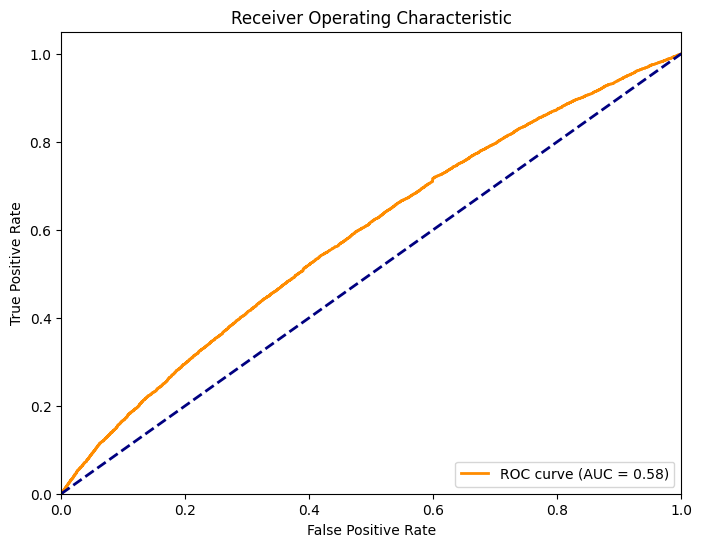

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Matrix Factorization Model

I will use AlternatingLeastSquares algorithm sinct it fits for the sparse matrix problem.
The algorithm utilizes Matrix Factorization technique which takes a user-item interaction matrix and factorize it into two lower-dimensional matrices:
- user matrix that represents the latent factors of users
- item matrix that epresents the latent factors of items  

where their interactions are modeled as dot products.

In [11]:
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix

In [ ]:
# First calculate desired size of the sets
train_size = int(len(df_filtered) * 0.85)

data = df_filtered.sort_values("reviewTime", ascending=True)
# Find the date in the last row of potential 'train' set
tr_last_value = data.iloc[:train_size]["reviewTime"].max()
# And separate all the data with dates before the maximum date including (this may result in a bit bigger size of dataset)
train_mf = data[data["reviewTime"] <= tr_last_value].copy()

# Separate all the dates after the maximum date not including (this may result in a bit smaller size of dataset)
test_mf = data[data["reviewTime"] > tr_last_value].copy()

In [ ]:
# Extract mappings for users and items. !For items full data is used, since all the items known at the date of prediction.
user_names = train_mf["userName"].unique()
item_names = train_mf["itemName"].unique()
user_mapping = {user_name: i for i, user_name in enumerate(user_names)}
item_mapping = {item_name: i for i, item_name in enumerate(item_names)}

In [ ]:
train_mf["userId"] = train_mf["userName"].map(user_mapping)
train_mf["itemId"] = train_mf["itemName"].map(item_mapping)

In [ ]:
test_filtered_mf = test_mf[test_mf["userName"].isin(user_names) & test_mf["itemName"].isin(item_names)].copy()
test_filtered_mf["userId"] = test_filtered_mf["userName"].map(user_mapping)
test_filtered_mf["itemId"] = test_filtered_mf["itemName"].map(item_mapping)

In [ ]:
sparse_item_user_train = csr_matrix((train_mf["rating"], (train_mf["userId"], train_mf["itemId"])))

model = AlternatingLeastSquares(factors=30, regularization=0.1, iterations=30)
model.fit(sparse_item_user_train)

In [ ]:
user_factors = model.user_factors
item_factors = model.item_factors

In [ ]:
def predict(user_id, item_id):
    user_vec = user_factors[user_id]
    item_vec = item_factors[item_id]
    score = np.dot(user_vec, item_vec)
    return score

In [ ]:
y_test_mf = test_filtered_mf["rating"]

In [ ]:
# Apply prediction to the test set
y_pred_score = test_filtered_mf.apply(lambda x: predict(x["userId"], x["itemId"]), axis=1)
# Normalize the predicted scores
y_pred_score = (y_pred_score - y_pred_score.min()) / (y_pred_score.max() - y_pred_score.min())

In [ ]:
threshold = y_pred_score.median()
print(classification_report(y_test_mf, (y_pred_score >= threshold).astype(int)))
fpr, tpr, thresholds = roc_curve(y_test_mf, y_pred_score)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Model Selection

There are several questions need to be addressed during model selection process:
- model efficiency (metrics)
- model maintanability
- resources availability (for training purposes)
- possibility to add new users / items

First, I'd like to explain metrics choosen:
- overall accuracy
- class 1 precision
- AUC


The task for the model is to identify the products that that user will rate with the 'maximum' score (5) which stands for positive label. Overall accuracy shows how precise model does predictions, i.e. how good it  can destinguish a good user-item fit. Class 1 precision shows how many good items were found out of the entire pool. The AUC shows for how good model outperforms random predictions.  
Unfortunately, both my models are not very accurate in recognizing good items but the Neural Network Model has a bit higher AUC score which tells that it performs a bit better the the Matrix Factorization Model.

In addition to that I would like to add, that it is much easier to improve Neural Network Model performance by adding more meaningful features. Such feature can be, for example, embedded users profiles collected from additional sources, like web browser cookies, search hiistory, or even social-economical characteristics, like household income, marital status, etc. And such additional features can help to solve 'cold start problem' when there is no way to estimate what products an user will like.

On the other hand, Matrix Factorization Model allows to add new customers only by complete retraining of the model, which is not computationally expensive, though.

In addition to the above, I would like to check how models performs with the specific task of recommending top 5 products for customers. The approach is not exact, but it still helps to evaluate the models.

The task is select only top 5 predictions out of the entires set of predictions for eahc user in the test dataset. This will ensure model's ability to prioritize, since items with the highest probability should be of class 1.

In [ ]:
nn_predictions = pd.DataFrame(index=test_filtered["userName"])

nn_predictions["y_true"] = y_test
nn_predictions["y_pred"] = y_pred_prob
nn_predictions = nn_predictions.reset_index()

In [ ]:
nn_top_predictions = nn_predictions.groupby("userName").apply(lambda x: x.nlargest(5, 'y_pred')).reset_index(drop=True)
nn_top_predictions.groupby("userName")["y_true"].mean().describe()

There are 14k unique users.  
66.6% of the users got right predictions, but there can be a case when user appeas only once in the dataset, which will highly affect the statistics, because we want to estimate multiple predictions for a user.

In [ ]:
nn_top_predictions.value_counts("userName").describe()

In [ ]:
for prods in range(1, 5):
    
    nn_people = nn_top_predictions.groupby("userName").size().loc[nn_top_predictions.groupby("userName").size() > prods].index
    print(
        f"Average success for group with more than {prods} product:",
        round(nn_top_predictions[nn_top_predictions["userName"].isin(nn_people)]["y_true"].mean(), 4) * 100
    )

In [ ]:
mf_predictions = pd.DataFrame(index=test_filtered_mf["userName"])

mf_predictions["y_true"] = y_test_mf.values
mf_predictions["y_pred"] = y_pred_score.values
mf_predictions = mf_predictions.reset_index()

In [ ]:
mf_top_predictions = mf_predictions.groupby("userName").apply(lambda x: x.nlargest(5, 'y_pred')).reset_index(drop=True)
mf_top_predictions.groupby("userName")["y_true"].mean().describe()

In [ ]:
mf_top_predictions.value_counts("userName").describe()

In [ ]:
for prods in range(1, 5):
    
    mf_people = mf_top_predictions.groupby("userName").size().loc[mf_top_predictions.groupby("userName").size() > prods].index
    print(
        f"Average success for group with more than {prods} product:",
        round(mf_top_predictions[mf_top_predictions["userName"].isin(mf_people)]["y_true"].mean(), 4) * 100
    )

## Conclusion

It seems like both models have pretty much the same efficiency and give almost 70% of good recommendations in the top 5 products and models do not assign high scores / probabilities to 'bad' items more often than to 'good' ones.

I will select Neural Network Model for the application because it is more promising in terms of AUC score and future option to improve using external data sources. But if extremely lightweighted solution is needed, the Matrix Factorization Model is an amazing choice.

In [37]:
model_path = os.path.join(os.getcwd(), "models")
os.makedirs(model_path, exist_ok=True)

In [38]:
model.save(os.path.join(model_path, "best_model.keras"))